# Final Project: Anime Recommendation System

**OVERVIEW**

**Recommendation systems** are widely used nowadays in this advanced century where quite a number of big companies applied them to improve their ratings and user satisfaction such as Youtube, Netfix, Amazon, Facebook etc. Netflix even offered a million dollars in 2009 to anyone who could improve its system by 10%.


Recommendation system can be classified into 3 groups:-

**1- SIMPLE RECOMMENDER SYSTEM**

**2- CONTENT-BASED RECOMMENDER SYSTEM**

**3- COLLABORATIVE FILTERING ENGINE**


In this project, I will build an Anime Recommendation System by using **content-based recommender** based on [here](https://www.kaggle.com/CooperUnion/anime-recommendations-database) database (anime.csv).

**DATA DICTIONARY**:

**anime_id** - Anime's unique identification code.

**title** - fThe title of anime.

**genre** - List of genre.

**type** - Movie, TV, OVA, etc.

**episodes** - Number of episodes of the anime (1 for movies).

**avg_rating** - Average rating out of 10 for the anime.

**members** - Number of people in the anime's community group.


**1) Importing necessary packages** and reading dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import re 
#for renaming the titles

from sklearn.feature_extraction.text import TfidfVectorizer
#for converting text into token counts

from sklearn.metrics.pairwise import cosine_similarity
#for calculating the similarity score

In [3]:
anime_data = pd.read_csv('../Data/anime.csv')
anime_data.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
anime_data.shape

(12294, 7)

In [5]:
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


**2) Modifying dataset** such as cleaning null values, renaming and etc.

In [6]:
#checking the number of null values
anime_data.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [7]:
#removing null values
anime_data.dropna(inplace=True)
#checking null values after removing
anime_data.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [8]:
anime_data.shape

(12017, 7)

The rows has decreased.

In [9]:
anime_data.tail()

,anime_id,name,genre,type,episodes,rating,members
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175
12293,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142


The index is not right because the dataset only have 12017 rows now. 

In [10]:
#reseting index of datasets
anime_data.reset_index(drop = True, inplace= True)
anime_data.tail()

,anime_id,name,genre,type,episodes,rating,members
12012,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12013,5543,Under World,Hentai,OVA,1,4.28,183
12014,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12015,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175
12016,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142


Indexing is fine now. Let's rename rating as avg_rating and name as title

In [11]:
#renaming columns
anime_data.rename(columns={'rating':'avg_rating','name':'title'},inplace = True)
anime_data.head()

,anime_id,title,genre,type,episodes,avg_rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


If we look at title column, the datas contain a lot of special symbols. Remove all the special symbols for better result.

In [12]:
#for an easy input later
anime_data['title'] = anime_data['title'].str.lower()

In [13]:
#define function for removing/renanimg the title column
def sym_cleaning(symbol):
    symbol = re.sub(r'&quot;', '', symbol)
    symbol = re.sub(r'.hack//', '', symbol)
    symbol = re.sub(r'&#039;', '', symbol)
    symbol = re.sub(r'A&#039;s', '', symbol)
    symbol = re.sub(r'I&#039;', 'I\'', symbol)
    symbol = re.sub(r'&amp;', 'and', symbol)
    symbol = re.sub(r'[.;!!:-]','', symbol)
    symbol = re.sub(r'°','', symbol)
    
    
    return symbol

anime_data['title'] = anime_data['title'].apply(sym_cleaning)

In [14]:
#checking title column
anime_data['title'].head(10)

0                                        kimi no na wa
1                      fullmetal alchemist brotherhood
2                                              gintama
3                                           steinsgate
4                                              gintama
5    haikyuu karasuno koukou vs shiratorizawa gakue...
6                               hunter x hunter (2011)
7                                 ginga eiyuu densetsu
8     gintama movie kanketsuhen  yorozuya yo eien nare
9                                    gintama enchousen
Name: title, dtype: object

In [15]:
anime_data.drop_duplicates(subset=['title'],inplace=True)
anime_data['title'].value_counts()

azarashi tamachan no hi no youjin            1
wakaba*girl onsen tsukaritai                 1
ryou seibai gakuen bishoujo seisai hiroku    1
dragon collection                            1
tenioe                                       1
                                            ..
nandarou                                     1
juuni kokuki                                 1
hayate no gotoku                             1
makenki                                      1
kaze no shoujo emily                         1
Name: title, Length: 11993, dtype: int64

In [16]:
anime_data['title'].head()

0                                        kimi no na wa
1                      fullmetal alchemist brotherhood
2                                              gintama
3                                           steinsgate
5    haikyuu karasuno koukou vs shiratorizawa gakue...
Name: title, dtype: object

**There we go!**

**3) Dataset statistics**

In [17]:
anime_data.describe()

,anime_id,avg_rating,members
count,11993.000000,11993.000000,1.199300e+04
mean,13637.977904,6.477031,1.821889e+04
std,11233.946374,1.023506,5.514493e+04
min,1.000000,1.670000,1.200000e+01
25%,3389.000000,5.890000,2.240000e+02
50%,9956.000000,6.570000,1.547000e+03
75%,23733.000000,7.180000,9.487000e+03
max,34519.000000,10.000000,1.013917e+06


Change anime_id column into type oblect because we don't want it in the statistics. anime_id is just an identification code for the anime.

In [18]:
anime_data['anime_id'] = anime_data['anime_id'].astype(object)
#checking dataset statistic after changing dtypes
anime_data.describe()

,avg_rating,members
count,11993.000000,1.199300e+04
mean,6.477031,1.821889e+04
std,1.023506,5.514493e+04
min,1.670000,1.200000e+01
25%,5.890000,2.240000e+02
50%,6.570000,1.547000e+03
75%,7.180000,9.487000e+03
max,10.000000,1.013917e+06


Let's proceed with scatter matrix plot to see the relation between avg_rating and members

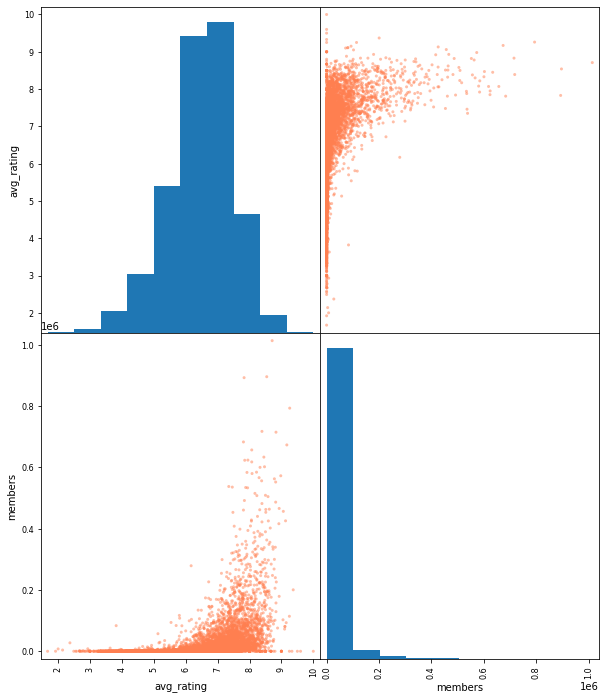

In [39]:
pd.plotting.scatter_matrix(anime_data,figsize=(10,12),color='coral');

**4) Visualization**

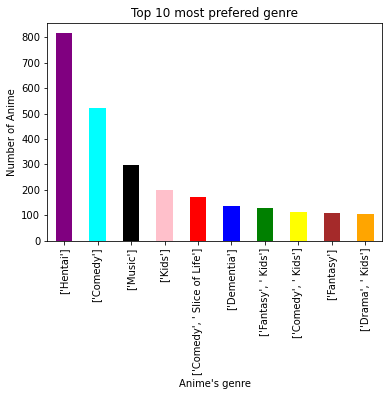

In [32]:
anime_data['genre'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar',color=['purple','cyan','black',
                                                                                                'pink','red','blue','green',
                                                                                                'yellow','brown','orange'])
plt.ylabel('Number of Anime')
plt.xlabel("Anime's genre")
plt.title('Top 10 most prefered genre');

Now we got 'Hentai' genre as the most loved anime's genre followed by Comedy in the second place and Music in the third.

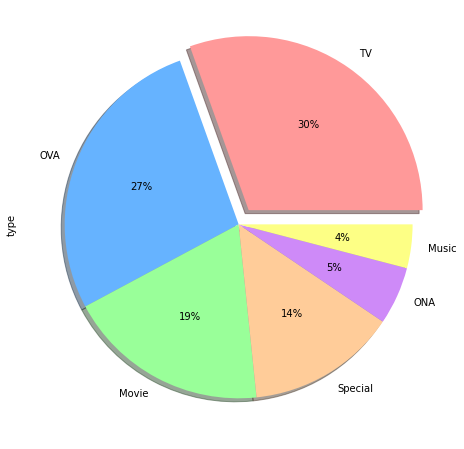

In [36]:
anime_data['type'].value_counts().plot(kind='pie',figsize=(10,8),autopct='%.0f%%',
                                       colors = ['#ff9999','#66b3ff','#99ff99',
                                                 '#ffcc99','#CE8AF8','#FDFF85'],
                                      shadow=True,explode = [0.1,0,0,0,0,0]);

Most people watched TV-type of anime.

**5) Cosine Similarity**

In [22]:
#define Tf-Idf vectorizer
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), 
                        min_df=0,stop_words='english')

#spliting the list by a comma (,)
anime_data['genre'] = anime_data['genre'].str.split(',').astype(str)

#construct tfidf matrix by fitting and transforming genre
tfidf_matrix = tfidf.fit_transform(anime_data['genre'])

#check the shape of matrix
tfidf_matrix.shape

(11993, 2680)

We have 2680 different vocabs/genres for 11993 animes

In [23]:
#construct cosine similarity matrix
cos_similar = cosine_similarity(tfidf_matrix, tfidf_matrix)
cos_similar.shape

(11993, 11993)

Now we have 11993**X**11993 matrix because we want each genre to get similarity score with every genre in the dataset

**6) Anime recommendation system**

Now, let's define a function that takes anime title as an input and outputs the top 10 most similar anime according to its genre

In [24]:
#getting the indices of anime title
indices = pd.Series(anime_data.index,index=anime_data['title']).drop_duplicates()
indices[:10]

title
kimi no na wa                                              0
fullmetal alchemist brotherhood                            1
gintama                                                    2
steinsgate                                                 3
haikyuu karasuno koukou vs shiratorizawa gakuen koukou     5
hunter x hunter (2011)                                     6
ginga eiyuu densetsu                                       7
gintama movie kanketsuhen  yorozuya yo eien nare           8
gintama enchousen                                          9
clannad after story                                       10
dtype: int64

In [25]:
def anime_rec(cos_similar = cos_similar):
    #get the index of anime that matches the title
    title = input('Please enter anime title: ')
    anime_idx = indices[title]
    
    #put the pairwise similarity score in a list
    similar_score = list(enumerate(cos_similar[anime_idx]))
    
    #sort based on similar scores
    similar_score = sorted(similar_score, key=lambda x: x[1],reverse=True)
    
    #get the top 10 similar scores
    similar_score = similar_score[1:11]
    
    #get anime indices
    anime_indices = [i[0] for i in similar_score]
    
    #return top 10 similarity scores
    return pd.DataFrame({'Anime title': anime_data['title'].iloc[anime_indices],
                                 'Rating': anime_data['avg_rating'].iloc[anime_indices]})


In [26]:
#example 1
anime_rec()

Please enter anime title: haikyuu


,Anime title,Rating
323,ef a tale of melodies,8.18
77,kara no kyoukai 7 satsujin kousatsu (kou),8.57
506,kara no kyoukai 2 satsujin kousatsu (zen),8.02
1014,kara no kyoukai 6 boukyaku rokuon,7.72
1998,bakemonogatari recap,7.38
392,ef a tale of memories,8.12
1410,ef a tale of memories recollections,7.55
1994,angel heart,7.38
1908,noir,7.41
297,kara no kyoukai 3 tsuukaku zanryuu,8.21


In [27]:
#example 2
anime_rec()

Please enter anime title: gintama


,Anime title,Rating
8,gintama movie kanketsuhen yorozuya yo eien nare,9.10
9,gintama enchousen,9.11
63,gintama yorinuki gintamasan on theater 2d,8.60
65,gintama movie shinyaku benizakurahen,8.59
216,gintama shinyaku benizakurahen,8.31
306,gintama jump festa 2014 special,8.20
361,gintama jump festa 2015 special,8.15
380,gintama nanigoto mo saiyo ga kanjin nano de ta...,8.13
4299,tono to issho,6.76
4423,tono to issho gantai no yabou,6.73


In [28]:
#example 3
anime_rec()

Please enter anime title: steinsgate


,Anime title,Rating
59,steinsgate movie fuka ryouiki no déjà vu,8.61
126,steinsgate oukoubakko no poriomania,8.46
196,steinsgate kyoukaimenjou no missing link divi...,8.34
5124,under the dog,6.55
5523,loups=garous,6.43
6885,loups=garous pilot,5.87
2518,ibara no ou,7.24
5475,arve rezzle kikaijikake no youseitachi,6.44
493,higashi no eden,8.03
365,paprika,8.15


In [29]:
#example 4
anime_rec()

Please enter anime title: toradora


,Anime title,Rating
35,howl no ugoku shiro,8.74
4848,palme no ki,6.62
723,hai to gensou no grimgar,7.87
4001,vampire hunter,6.83
10663,wan wan chuushingura,6.12
3408,fushigi yuugi eikouden,7.00
210,nagi no asukara,8.32
2280,sekai meisaku douwa hakuchou no mizuumi,7.31
3390,sirius no densetsu,7.01
5867,kurumiwari ningyou,6.33


In [30]:
#example 5
anime_rec()

Please enter anime title: kimi no na wa


,Anime title,Rating
5803,wind a breath of heart ova,6.35
6391,wind a breath of heart (tv),6.14
1111,aura maryuuin kouga saigo no tatakai,7.67
208,kokoro ga sakebitagatterunda,8.32
504,"clannad after story mou hitotsu no sekai, kyo...",8.02
1435,true tears,7.55
1436,bungaku shoujo memoire,7.54
1631,kimikiss pure rouge,7.48
1907,myself yourself,7.41
2300,koi to senkyo to chocolate,7.30


**CONCLUSION**

My anime recommendation system is not 100% accurate. From the examples above, we can see that the function worked for some animes but returned inaccurate for some animes. Basically, content-based recommender would outputs the most similar animes (or anything) according to user's input, the general idea behind these recommender systems is that if a person likes a particular item, he or she will also like an item that is similar to it. An example of a good content-based recommender would be Youtube.

**REFFERENCE**

1) https://www.kaggle.com/lavanyaanandm/recommending-anime-s-using-all-recommendation-sys

2)https://medium.com/analytics-vidhya/anime-recommendation-engine-content-collaborative-filtering-c6e69be29d29

3)https://www.datacamp.com/community/tutorials/recommender-systems-python

4)https://www.machinelearningplus.com/nlp/cosine-similarity/